In [1]:
# Prepare data for 2D resnet for distances prediction
import numpy as np
import matplotlib.pyplot as plt
# Keras specific
import keras
import keras.backend as K
from keras.regularizers import l2
from keras.losses import mean_squared_error, mean_absolute_error
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Embedding, Dropout, Flatten, UpSampling2D, Input, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
# Model architecture
from elu_resnet_2d_distances import *

Using TensorFlow backend.


# Loading the Dataset

In [2]:
def parse_lines(raw):
    return [[float(x) for x in line.split("\t") if x != ""] for line in raw]

def parse_line(line):
    return [float(x) for x in line.split("\t") if x != ""]

In [3]:
path = "../data/distanced/70_full_under_200.txt"
# Opn file and read text
with open(path, "r") as f:
    lines = f.read().split('\n')

In [4]:
# Scan first n proteins
names = []
seqs = []
dists = []
pssms = []

# Extract numeric data from text
for i,line in enumerate(lines):
    if len(names) == 1500:
        break
    # Read each protein separately
    if line == "[ID]":
        names.append(lines[i+1])
    elif line == "[PRIMARY]":
        seqs.append(lines[i+1])
    elif line == "[EVOLUTIONARY]":
        pssms.append(parse_lines(lines[i+1:i+21]))
    elif line == "[DIST]":
        dists.append(parse_lines(lines[i+1:i+len(seqs[-1])+1]))
        # Progress control
        if len(names)%50 == 0:
            print("Currently @ ", len(names), " out of n (500)")

Currently @  50  out of n (500)
Currently @  100  out of n (500)
Currently @  150  out of n (500)
Currently @  200  out of n (500)
Currently @  250  out of n (500)
Currently @  300  out of n (500)
Currently @  350  out of n (500)
Currently @  400  out of n (500)
Currently @  450  out of n (500)
Currently @  500  out of n (500)
Currently @  550  out of n (500)
Currently @  600  out of n (500)
Currently @  650  out of n (500)
Currently @  700  out of n (500)
Currently @  750  out of n (500)
Currently @  800  out of n (500)
Currently @  850  out of n (500)
Currently @  900  out of n (500)
Currently @  950  out of n (500)
Currently @  1000  out of n (500)
Currently @  1050  out of n (500)
Currently @  1100  out of n (500)
Currently @  1150  out of n (500)
Currently @  1200  out of n (500)


In [6]:
print("Names: ", len(names))
print("Seqs: ", len(seqs))
print("Dists: ", len(dists))
print("Pssms: ", len(pssms))

Names:  1204
Seqs:  1204
Dists:  1204
Pssms:  1204


In [7]:
# DEFINE MODEL PARAMS
CROP_SIZE = 200                                      # Crops to feed the mmodel   
PAD_SIZE = 200                                       # Maximum length of any protein
CLASS_CUTS = [-0.5, 500, 750, 1000, 1400, 1700] # , 2000 # Cuts between classes 
N_CLASSES = len(CLASS_CUTS)+1                        # Number of classes
BATCH_SIZE = 2                                       # Size of each batch

## Set the data generators (don't keep all the data in memory)

In [8]:
# Import the Data Generator
from distance_generator_changes import DataGenerator

In [9]:
splice = int(len(seqs)*0.1)
print(splice)
# Instantiate DataGenerator - Parameters
params_train = {'seqs': seqs[splice:],
                'pssms': pssms[splice:],
                'dists': dists[splice:],
                'batch_size': BATCH_SIZE,
                'crop_size': CROP_SIZE,
                'pad_size': PAD_SIZE,
                'n_classes': N_CLASSES,
                'class_cuts': CLASS_CUTS,
                'shuffle': False}

params_val = {'seqs': seqs[:splice],
              'pssms': pssms[:splice],
              'dists': dists[:splice],
              'batch_size': BATCH_SIZE,
              'crop_size': CROP_SIZE,
              'pad_size': PAD_SIZE,
              'n_classes': N_CLASSES,
              'class_cuts': CLASS_CUTS,
              'shuffle': False}

# Data generator for training
training_generator = DataGenerator(**params_train)
# Data generator for validation
# validation_generator = DataGenerator(**params_val)

120


# Loading the model

In [10]:
weighter = {0: 0.0000001, 1: 0.45, 2: 1.65, 3: 1.75, 4: 0.73, 5: 0.77, 6: 0.145}
weights = [weighter[i] for i in range(len(weighter.keys()))][:N_CLASSES]
print(weights)

[1e-07, 0.45, 1.65, 1.75, 0.73, 0.77, 0.145]


In [11]:
kernel_size, filters = 3, 16
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

In [12]:
model = load_model("tester_28.h5",
                   custom_objects={'loss': weighted_categorical_crossentropy(np.array(weights)),
                                   'softMaxAxis2': softMaxAxis2})

In [13]:
model.compile(optimizer=adam, loss=weighted_categorical_crossentropy(np.array(weights)), metrics=["accuracy"]) 
# "categorical_crossentropy" || class_weight=weighter, 
# model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"]) 
model.summary() 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 42) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 200, 64) 24256       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200, 200, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 200, 200, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [14]:
# Train model on dataset
model.fit_generator(generator=training_generator,
                          # validation_data=validation_generator,
                          use_multiprocessing=False,
                          workers=1,
                          steps_per_epoch=(len(seqs)-splice)//(BATCH_SIZE), # (len(seqs) // BATCH_SIZE),
                          epochs=1,
                          verbose=1,
                          shuffle=True)

Epoch 1/1
360/360 [==============================] - 242s 673ms/step - loss: 0.2726 - acc: 0.1744


In [14]:
def wider(seq, l=200, n=20):
    """ Converts a seq into a one-hot tensor. Not LxN but LxLxN"""
    key = "HRKDENQSYTCPAVLIGFWM"
    tensor = []
    for i in range(l):
        d2 = []
        for j in range(l):
            d1 = [1 if (j<len(seq) and i<len(seq) and key[x] == seq[i] and key[x] == seq[j]) else 0 for x in range(n)]
    
            d2.append(d1)
        tensor.append(d2)
    
    return np.array(tensor)

In [15]:
def wider_pssm(pssm, seq, l=200, n=20):
    """ Converts a seq into a one-hot tensor. Not LxN but LxLxN"""
    key = "HRKDENQSYTCPAVLIGFWM"
    key_alpha = "ACDEFGHIKLMNPQRSTVWY"
    tensor = []
    for i in range(l):
        d2 = []
        for j in range(l):
            if (i==j and j<len(seq) and i<len(seq)):
                d1 = [aa[i] for aa in pssm]
            else:
                d1 = [0 for i in range(n)]
                
            # Append pssm[i]*pssm[j]
            if j<len(seq) and i<len(seq):
                d1.append(pssm[key_alpha.index(seq[i])][i] *
                          pssm[key_alpha.index(seq[j])][j])
            else: 
                d1.append(0)
            # Append manhattan distance to diagonal abs(i-j)*2/crop_size
            # Works bad when i,j > len(seq)
            d1.append(1 - abs(i-j)/200)
    
            d2.append(d1)
        tensor.append(d2)
    
    return np.array(tensor)

In [16]:
# Embed number of rows
def embedding_matrix(matrix, l=200):
    # Embed with extra columns
    for i in range(len(matrix)):
        while len(matrix[i])<l:
            matrix[i].extend([-1 for i in range(l-len(matrix[i]))])
    #Embed with extra rows
    while len(matrix)<l:
        matrix.append([-1 for x in range(l)])
    return np.array(matrix)

In [17]:
def treshold(matrix, cuts=CLASS_CUTS, l=200): #[-0.5, 500, 750, 1000, 1250, 1600, 2000] [-0.5, 500, 750, 1000, 1400, 1700]
    # Turns an L*L*1 tensor into an L*L*N 
    trash = (np.array(matrix)<cuts[0]).astype(np.int)
    first = (np.array(matrix)<cuts[1]).astype(np.int)-trash
    sec = (np.array(matrix)<cuts[2]).astype(np.int)-trash-first
    third = (np.array(matrix)<cuts[3]).astype(np.int)-trash-first-sec
    fourth = (np.array(matrix)<cuts[4]).astype(np.int)-trash-first-sec-third
    fifth = (np.array(matrix)<cuts[5]).astype(np.int)-trash-first-sec-third-fourth
#     sixth = (np.array(matrix)<cuts[6]).astype(np.int)-trash-first-sec-third-fourth-fifth
    seventh = np.array(matrix)>=cuts[5]

    return np.concatenate((trash.reshape(l,l,1),
                           first.reshape(l,l,1),
                           sec.reshape(l,l,1),
                           third.reshape(l,l,1),
                           fourth.reshape(l,l,1),
                           fifth.reshape(l,l,1),
                           # sixth.reshape(l,l,1),
                           seventh.reshape(l,l,1)),axis=2)

In [18]:
n_test = 15

In [19]:
inputs_aa = np.array([wider(seqs[i]) for i in range(n_test)])

In [20]:
inputs_pssm = np.array([wider_pssm(pssms[i], seqs[i]) for i in range(n_test)])

In [21]:
distas = np.array([embedding_matrix(dists[i]) for i in range(n_test)])
outputs = np.array([treshold(d) for d in distas])  

In [22]:
inputs = np.concatenate((inputs_aa, inputs_pssm), axis=3)
print(inputs.shape)
print(outputs.shape)
print("N_test: ", n_test)
# delete unnecessary data
del distas
del inputs_aa
del inputs_pssm

(15, 200, 200, 42)
(15, 200, 200, 7)
N_test:  15


In [23]:
def mirror_diag(image):
    image = image.astype(float)
    # averages image across diagonal and returns 2 simetric parts
    for i in range(len(image)):
        for j in range(len(image[i])):
            image[i,j] = image[j,i] = np.true_divide((image[i,j]+image[j,i]), 2)
         
    return image

In [24]:
sample_pred = model.predict(inputs)

In [25]:
preds4 = np.argmax(sample_pred, axis=3)
preds4[preds4==0] = 6 # Change trash class by class for long distance

In [26]:
outs4 = np.argmax(outputs, axis=3)
outs4[outs4==0] = 6 # Change trash class by class for long distance

In [27]:
i = 0
# Select the best prediction to display it - (proportional by protein length(area of contact map))
results = [np.sum(np.equal(pred[:len(seqs[i+j]), :len(seqs[i+j])], outs4[j, :len(seqs[i+j]), :len(seqs[i+j]),]),axis=(0,1))/
           len(seqs[i+j])**2 
           for j,pred in enumerate(preds4)]
best_score = max(results)
print("Best score (Accuracy): ", best_score)
sorted_scores = [acc for acc in sorted(results, key=lambda x: x, reverse=True)]
print("Best 5 scores: ", sorted_scores[:5])
print("Best 5 indices: ", [results.index(x) for x in sorted_scores[:5]])
best_score_index = results.index(best_score)
print("Index of best score: ", best_score_index)  

Best score (Accuracy):  0.6707168324263464
Best 5 scores:  [0.6707168324263464, 0.6231900200490087, 0.607616, 0.6011278511909772, 0.600346565847511]
Best 5 indices:  [1, 8, 12, 11, 4]
Index of best score:  1


In [28]:
best_score_index = 1 # 7,8,3,9,5   || 2, 0
i=0

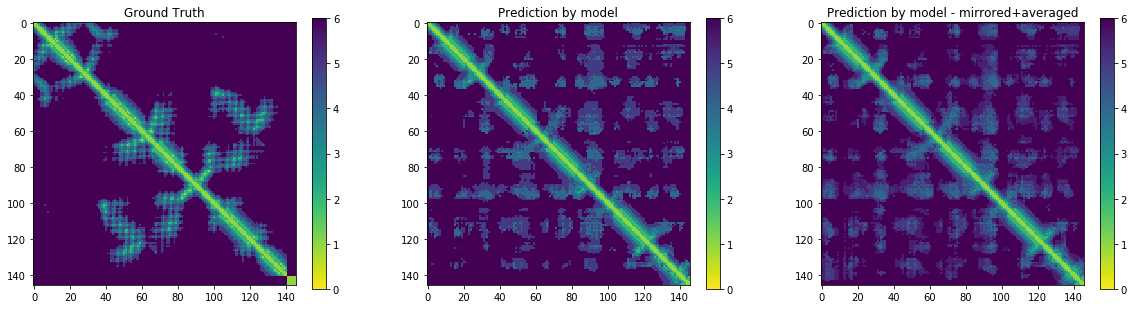

In [29]:
plt.figure(figsize=(20,5))
# First plot Ground Truth
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
plt.imshow(outs4[best_score_index, :len(seqs[i+best_score_index]), :len(seqs[i+best_score_index])],
           cmap='viridis_r', interpolation='nearest')
plt.colorbar()
plt.clim(0, N_CLASSES-1)

# Then plot predictions by the mode
plt.subplot(1, 3, 2)
plt.title("Prediction by model")
plt.imshow(preds4[best_score_index, :len(seqs[i+best_score_index]), :len(seqs[i+best_score_index])],
           cmap='viridis_r', interpolation='nearest')
plt.colorbar()
plt.clim(0, N_CLASSES-1)

# Prediction by model (diag mirrored)
plt.subplot(1, 3, 3)
plt.title("Prediction by model - mirrored+averaged")
plt.imshow(mirror_diag(preds4[best_score_index, :len(seqs[i+best_score_index]), :len(seqs[i+best_score_index])]),
           cmap='viridis_r', interpolation='nearest')
plt.colorbar()
plt.clim(0, N_CLASSES-1)

# Show them
# plt.savefig("../images/huge_prots_"+str(best_score_index)+".png")
plt.show()

## Some metrics

In [30]:
# Done!
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [31]:
preds_crop = np.concatenate( [pred[:len(seqs[i+j]), :len(seqs[i+j])].flatten() for j,pred in enumerate(preds4)] )
outs_crop = np.concatenate( [outs4[j, :len(seqs[i+j]), :len(seqs[i+j])].flatten() for j,pred in enumerate(preds4)] )

Introducing total mse:  585.3639893262995
Introducing mse/prot:  29.268199466314975


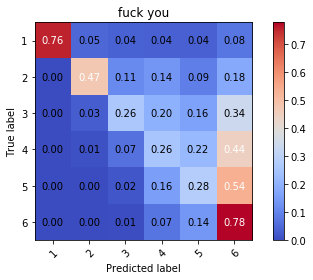

In [32]:
# PREDICTING FIRST 25 PROTS
matrix = cm = confusion_matrix(outs_crop, preds_crop)

classes = [i+1 for i in range(6)]
title = "fuck you"
cmap = "coolwarm"
normalize = True

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')
#     
# print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

print("Introducing total mse: ", np.linalg.norm(outs_crop-preds_crop))
print("Introducing mse/prot: ", np.linalg.norm(outs_crop-preds_crop)/len(preds4))

# Done!